# **Análisis Exploratorio de Datos (EDA) Inicial: EMNIST ByClass**

A continuación se detalla el Análisis Exploratorio de Datos (EDA) del dataset **EMNIST ByClass**, que incluye 62 clases (dígitos 0-9, letras mayúsculas A-Z y minúsculas a-z).

La estrategia se centra en:
1.  Inspeccionar la **Dimensionalidad** y el **Volumen** de los datos.
2.  Analizar el **Desequilibrio de la Variable Objetivo** (clase).
3.  Determinar los pasos de **Preprocesamiento** críticos.

## **I. Configuración e Importación de Librerías**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import collections

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

## **Carga de Datos y Transformación Inicial del Dataset EMNIST**

Esta sección ejecuta el proceso completo de adquisición y preparación inicial de los datos. Se utiliza `kagglehub` para descargar el dataset *EMNIST ByClass* y se leen los archivos CSV para cargarlos en memoria.

Dado que el dataset EMNIST se almacena originalmente como vectores planos de 784 píxeles, se requieren dos pasos de preprocesamiento previos:

1.  **Remodelación:** Convertir el vector $(N, 784)$ a una matriz $(N, 28, 28)$.
2.  **Corrección de Orientación:** El dataset se genera con una rotación de $90^\circ$. Las imágenes se rotan para asegurar que los caracteres sean legibles.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

100%|██████████| 1.24G/1.24G [00:11<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/emnist/versions/3


In [4]:
import os

# Ruta al dataset descargado
data_path = "/root/.cache/kagglehub/datasets/crawford/emnist/versions/3"

# Leer los archivos directamente desde esa ruta
train = pd.read_csv(os.path.join(data_path, 'emnist-byclass-train.csv'), header=None, dtype=np.uint8).values
test = pd.read_csv(os.path.join(data_path, 'emnist-byclass-test.csv'), header=None, dtype=np.uint8).values

# Separar datos y etiquetas
X_train = train[:, 1:].astype(np.uint8, copy=False)
X_test = test[:, 1:].astype(np.uint8, copy=False)
y_train = train[:, 0].flatten().astype(np.uint8, copy=False)
y_test = test[:, 0].flatten().astype(np.uint8, copy=False)

# Reshape de (N, 784) a (N, 28, 28)
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Rotar imágenes para orientación correcta
X_train = np.fliplr(np.rot90(X_train, k=3, axes=(1, 2)))
X_test = np.fliplr(np.rot90(X_test, k=3, axes=(1, 2)))

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Pixel value range: {X_train.min()} to {X_train.max()}")
print(f"Label value range: {y_train.min()} to {y_train.max()}")

Training set shape: (697932, 28, 28)
Test set shape: (116323, 28, 28)
Training labels shape: (697932,)
Test labels shape: (116323,)
Pixel value range: 0 to 255
Label value range: 0 to 61


## **Características Principales del Problema**

Tras la carga, corrección de orientación y verificación de la dimensionalidad, se confirman los siguientes hallazgos clave:

* **Volumen Masivo:** Se cuenta con más de **814,000 muestras totales** (casi 700k para entrenamiento). Este gran volumen es una fortaleza que mitiga significativamente el riesgo de **sobreajuste (*overfitting*)** para modelos complejos.
* **Dimensionalidad:** Las imágenes son de **$28 \times 28$ píxeles**, resultando en 784 *features*. La baja dimensionalidad permite un procesamiento eficiente.
* **Clasificación Multi-clase:** El problema exige la distinción entre **62 clases** diferentes, aumentando la complejidad por la similitud visual entre caracteres (e.g., '0' vs. 'O' vs. 'o').

## **Mapeo de Clases**

Para garantizar la interpretabilidad de los resultados, es necesario mapear los identificadores numéricos de la etiqueta (`y_train`, `y_test`) a sus correspondientes caracteres ASCII.

In [5]:
mapping_path = os.path.join(data_path, "emnist-byclass-mapping.txt")
mapping_df = pd.read_csv(mapping_path, sep='\s+', header=None, names=['label', 'ascii'])
mapping_df = mapping_df.sort_values('label')
class_mapping = {int(row.label): chr(int(row.ascii)) for _, row in mapping_df.iterrows()}

print(f"Total classes: {len(class_mapping)}")
print(f"Class mapping: {class_mapping}")

Total classes: 62
Class mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2542962881.py:2: SyntaxWarning: invalid escape sequence '\s'
  mapping_df = pd.read_csv(mapping_path, sep='\s+', header=None, names=['label', 'ascii'])


## **Resultado del Mapeo**

El problema de clasificación aborda 62 clases distintas, desde '0' hasta 'z' entre dígitos, mayúsculas y minúsculas.

## **Inspección de Muestras Aleatorias**

Se selecciona y muestra 10 imágenes aleatorias del conjunto de entrenamiento para verificar que la corrección de orientación fue exitosa y para obtener una primera inspección visual de la calidad y el estilo de la escritura.

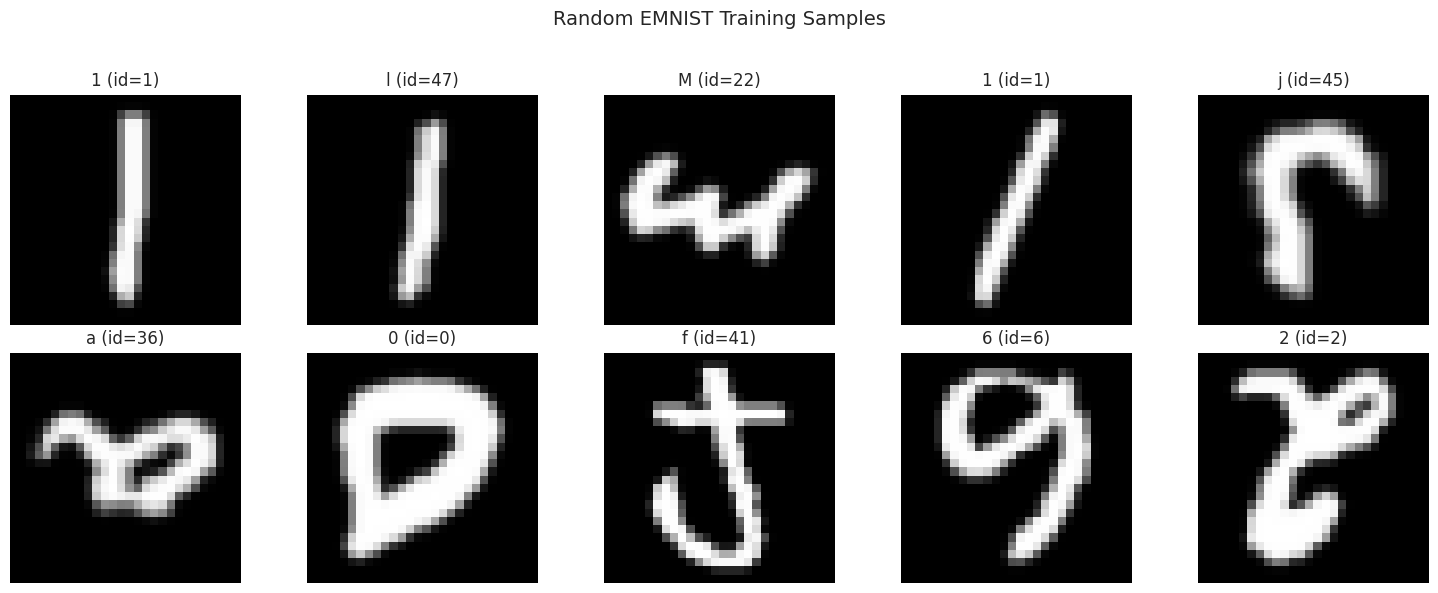

In [6]:
rng = np.random.default_rng()
indices = rng.choice(X_train.shape[0], size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(X_train[idx], cmap='gray')
    label = class_mapping.get(int(y_train[idx]), int(y_train[idx]))
    ax.set_title(f"{label} (id={int(y_train[idx])})")
    ax.axis('off')

plt.suptitle("Random EMNIST Training Samples", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **Conteo de Clases y Análisis del Desequilibrio**

Se realiza un conteo detallado por clase tanto en el set de entrenamiento como en el de prueba para verificar el soporte muestral y su consistencia.

In [7]:
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

train_df = pd.DataFrame(list(train_counts.items()), columns=['class_id', 'count'])
train_df['class_name'] = train_df['class_id'].map(class_mapping)

test_df = pd.DataFrame(list(test_counts.items()), columns=['class_id', 'count'])
test_df['class_name'] = test_df['class_id'].map(class_mapping)

print("Training set class distribution:")
for class_id in sorted(train_counts.keys()):
    class_name = class_mapping.get(class_id, f"Unknown ({class_id})")
    print(f"    {class_name}: {train_counts[class_id]:,}")

print("\nTest set class distribution:")
for class_id in sorted(test_counts.keys()):
    class_name = class_mapping.get(class_id, f"Unknown ({class_id})")
    print(f"    {class_name}: {test_counts[class_id]:,}")

Training set class distribution:
    0: 34,585
    1: 38,374
    2: 34,203
    3: 35,143
    4: 33,535
    5: 31,416
    6: 34,232
    7: 35,754
    8: 33,946
    9: 33,847
    A: 6,407
    B: 3,878
    C: 10,094
    D: 4,562
    E: 4,934
    F: 9,182
    G: 2,517
    H: 3,152
    I: 11,946
    J: 3,762
    K: 2,468
    L: 5,076
    M: 9,002
    N: 8,237
    O: 24,983
    P: 8,347
    Q: 2,605
    R: 5,073
    S: 20,764
    T: 9,820
    U: 12,602
    V: 4,637
    W: 4,695
    X: 2,771
    Y: 4,743
    Z: 2,701
    a: 10,033
    b: 5,159
    c: 2,854
    d: 10,177
    e: 24,631
    f: 2,561
    g: 3,687
    h: 8,738
    i: 2,725
    j: 1,896
    k: 2,491
    l: 15,318
    m: 2,645
    n: 11,418
    o: 2,749
    p: 2,448
    q: 2,994
    r: 14,105
    s: 2,699
    t: 18,262
    u: 2,830
    v: 2,910
    w: 2,697
    x: 2,822
    y: 2,365
    z: 2,725

Test set class distribution:
    0: 5,778
    1: 6,330
    2: 5,869
    3: 5,969
    4: 5,619
    5: 5,190
    6: 5,705
    7: 6,139
    8

## **Hallazgos del Conteo de Clases**

Los resultados muestran que existe una **variación significativa** en el soporte de las 62 clases. Mientras que los dígitos ('0' a '9') son clases mayoritarias, muchas letras (e.g., 'G', 'K', 'j', 'z') son clases minoritarias con un conteo considerablemente menor. Este desequilibrio requiere que la evaluación del modelo use métricas como **F1-Score ponderado** o el **Recall/Precision por clase**, ya que la Accuracy global sería engañosa.

### **Análisis del Desequilibrio de la Variable Objetivo (Clase)**

El desequilibrio de clases constituye uno de los **hallazgos más críticos** para la correcta evaluación del modelo.  
Se analiza la distribución de las **62 clases** presentes en los conjuntos de **entrenamiento y prueba**, representadas mediante **gráficos de barras** que permiten identificar diferencias de frecuencia entre categorías.

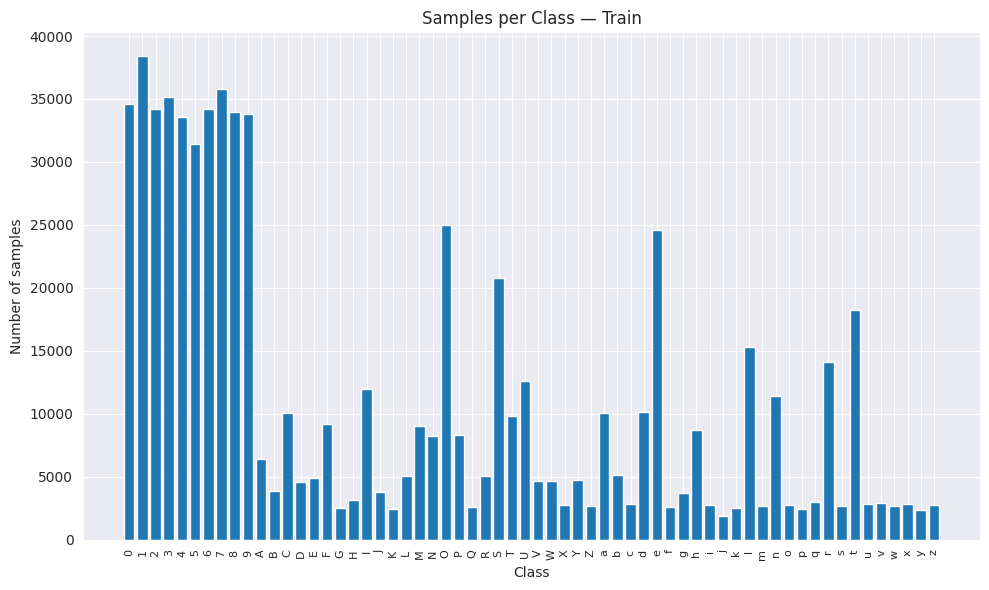

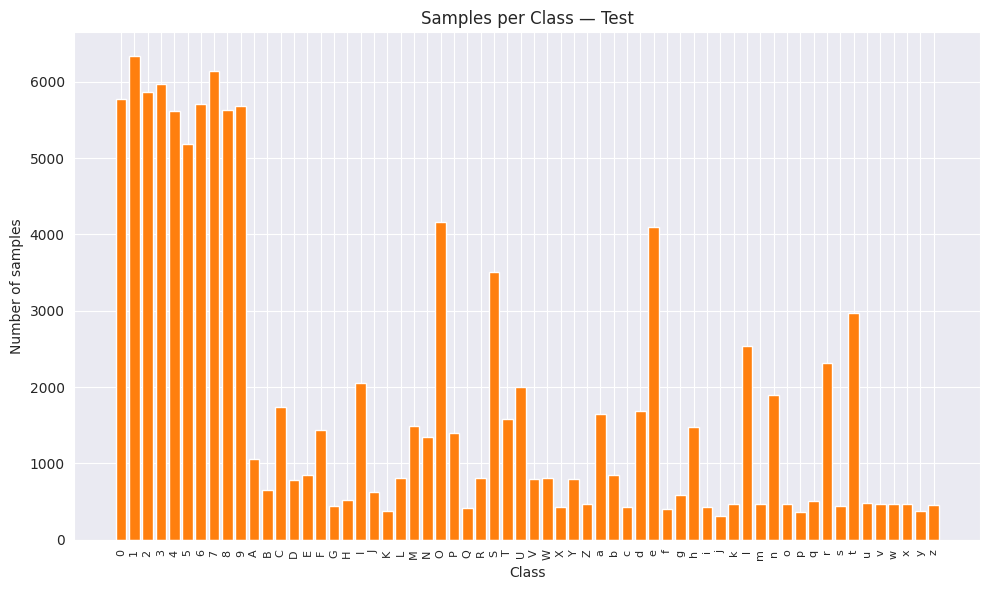

In [8]:
class_ids = sorted(class_mapping.keys())

train_series = pd.Series(train_counts).reindex(class_ids, fill_value=0)
test_series = pd.Series(test_counts).reindex(class_ids, fill_value=0)
class_names = [class_mapping[cid] for cid in class_ids]

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_ids)), train_series.values, color='tab:blue')
plt.xticks(range(len(class_ids)), class_names, rotation=90, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Samples per Class — Train')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_ids)), test_series.values, color='tab:orange')
plt.xticks(range(len(class_ids)), class_names, rotation=90, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Samples per Class — Test')
plt.tight_layout()
plt.show()

## **Hallazgos de la Distribución de Clases**

**Variación de Conteo:**  
Los gráficos muestran que, aunque la distribución general mantiene una forma similar entre los conjuntos, existen **diferencias notables en el número de muestras por clase**. Algunas letras y dígitos presentan un soporte mucho menor.

**Riesgo de Sesgo:**  
La existencia de **clases minoritarias** introduce un **riesgo elevado de sesgo**, ya que el modelo podría aprender patrones dominantes y **reducir su _recall_** para las clases menos representadas.

**Requisito de Métrica:**  
La ***accuracy*** global **no es suficiente** para medir el rendimiento real del modelo.  
Se recomienda utilizar métricas como el **F1-Score ponderado** o el **Recall/Precision por clase**, las cuales **consideran el desequilibrio** y ofrecen una evaluación más justa del desempeño.

## **Análisis de Dimensionalidad y Volumen del Problema**

Este primer análisis caracteriza la magnitud del dataset. Es fundamental para determinar el modelo de reconocimiento de patrones a emplear, dado el alto número de clases y el volumen masivo de muestras.

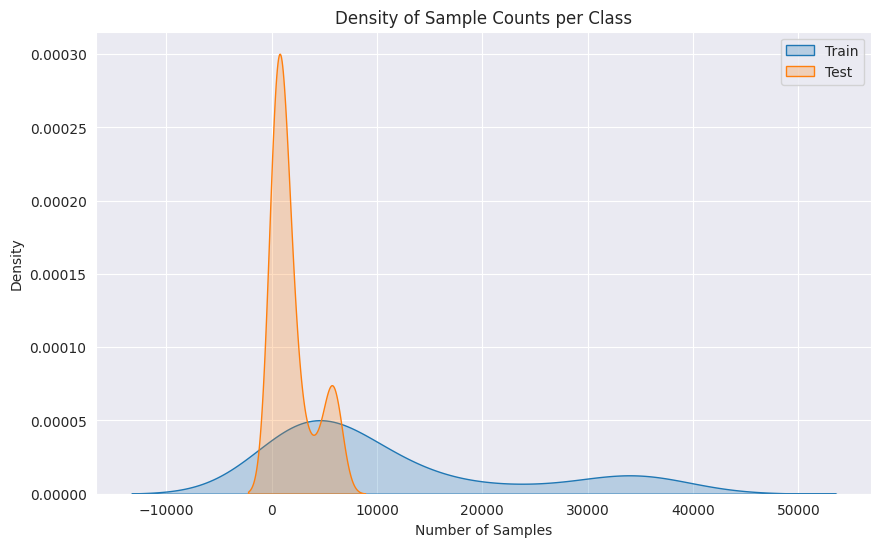

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['count'], label='Train', fill=True)
sns.kdeplot(test_df['count'], label='Test', fill=True)
plt.title('Density of Sample Counts per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Total samples: {X_train.shape[0] + X_test.shape[0]:,}")
print(f"Image dimensions: {X_train.shape[1]} x {X_train.shape[2]} pixels")
print(f"Number of classes: {len(np.unique(y_train))}")

Training samples: 697,932
Test samples: 116,323
Total samples: 814,255
Image dimensions: 28 x 28 pixels
Number of classes: 62


## **Resultados del Análisis de Dimensionalidad**

**Volumen Masivo:**  
Se cuenta con un total de **814,255 muestras**, que representa un beneficio, ya que **reduce el riesgo de *overfitting***.

**Dimensionalidad Baja:**  
Cada imagen tiene una resolución de **$28 \times 28$ píxeles**, lo que proporciona un balance ideal entre detalle visual y eficiencia computacional, cubriendo la necesidad de realizar una **reducción dimensional agresiva**, manteniendo información visual necesaria para el aprendizaje.

**Complejidad de Clases:**  
El conjunto de datos aborda un problema de clasificación multiclase con **62 clases únicas** (dígitos, letras mayúsculas y minúsculas).  
Esta alta diversidad **aumenta la complejidad del reconocimiento de patrones**, requiriendo modelos capaces de capturar diferencias sutiles entre caracteres similares.


## **Análisis de la Escala de Píxeles**

Para caracterizar las **variables predictoras de entrada (píxeles)**, se implementa un análisis de la escala, la distribución de intensidad y la dimensionalidad estructural.

Este enfoque es fundamental para fundamentar la selección adecuada de técnicas de modelado y preprocesamiento, ya que identifica las transformaciones obligatorias que deben aplicarse a la matriz de *features* antes de la fase de entrenamiento. La verificación del rango de valores y la forma de los datos es crítica para asegurar la estabilidad, la eficiencia computacional y el correcto ingreso al modelo de reconocimiento de patrones.

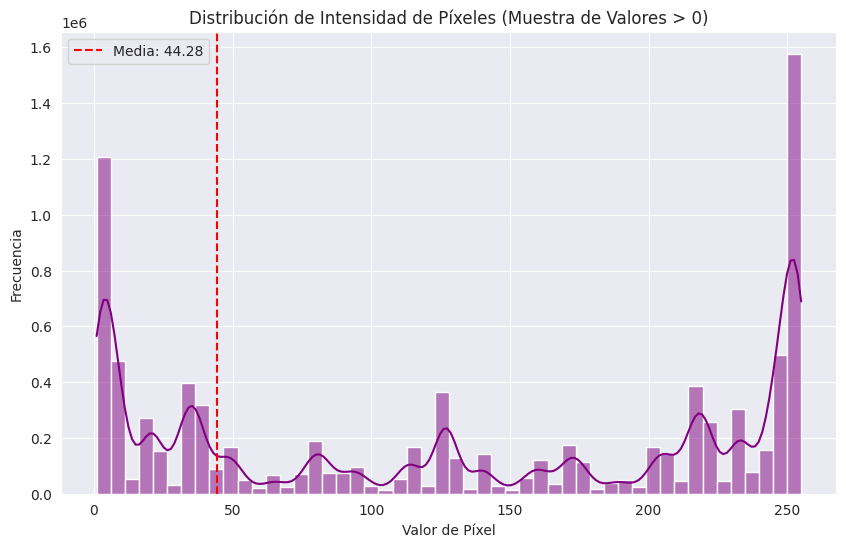


ESTADÍSTICAS CLAVE DE PÍXELES:
   • Mínimo: 0
   • Máximo: 255
   • Tipo de dato: uint8

FORMA REQUERIDA PARA EL CLASIFICADOR DE IMÁGENES:
   • Forma actual: (697932, 28, 28)
   • Forma necesaria: (697932, 28, 28, 1)


In [13]:
# Tomamos una muestra representativa del 5 % de los píxeles
sample_size = int(0.05 * X_train.size)
indices = np.random.choice(X_train.size, sample_size, replace=False)
X_train_flat_sample = X_train.flatten()[indices]

plt.figure(figsize=(10, 6))
sns.histplot(X_train_flat_sample[X_train_flat_sample > 0], bins=50, kde=True, color='purple')
plt.title('Distribución de Intensidad de Píxeles (Muestra de Valores > 0)')
plt.xlabel('Valor de Píxel')
plt.ylabel('Frecuencia')
plt.axvline(X_train_flat_sample.mean(), color='red', linestyle='--',
            label=f'Media: {X_train_flat_sample.mean():.2f}')
plt.legend()
plt.show()

# Estadísticas clave
print(f"\nESTADÍSTICAS CLAVE DE PÍXELES:")
print(f"   • Mínimo: {X_train.min()}")
print(f"   • Máximo: {X_train.max()}")
print(f"   • Tipo de dato: {X_train.dtype}")

# Forma requerida para redes convolucionales (CNN)
print(f"\nFORMA REQUERIDA PARA EL CLASIFICADOR DE IMÁGENES:")
print(f"   • Forma actual: {X_train.shape}")
print(f"   • Forma necesaria: ({X_train.shape[0]}, {X_train.shape[1]}, {X_train.shape[2]}, 1)")

## **Implicaciones estratégicas**

Los resultados validan la necesidad de dos pasos de preprocesamiento esenciales para el clasificador de imágenes:

* **Normalización:** El rango de píxeles **$[0, 255]$** y el tipo `uint8` exigen que la data sea escalada al rango **$[0, 1]$** y convertida a tipo flotante para la reducción del tiempo de convergencia), garantizando la eficiencia del algoritmo de entrenamiento.
* **Remodelación:** La forma actual 3D $(N, 28, 28)$ debe ser transformada a **4D $(N, 28, 28, 1)$**, añadiendo el canal de escala de grises para asegura que la estructura del *feature* de entrada sea compatible con la arquitectura de reconocimiento de patrones espaciales.

## **IV. Conclusiones**

Para lograr un rendimiento óptimo y abordar los hallazgos del EDA, se propone:

1.  **Normalización:** Aplicar la normalización de píxeles dividiendo por 255.
    * *Justificación:* Acelera la convergencia de la CNN.

2.  **Mitigación de Desequilibrio:** Implementar **ponderación de clases (*class weighting*)** en la función de pérdida.
    * *Justificación:* Es la mejor técnica para imágenes en este contexto, ya que penaliza los errores en las clases minoritarias sin alterar la distribución de los datos originales.

3.  **Métrica de Evaluación:** Adoptar el **F1-score ponderado (*weighted F1-score*)** como métrica principal.
    * *Justificación:* Considera explícitamente el desequilibrio al ponderar el *precision* y *recall* por el soporte de cada clase, proporcionando una evaluación justa y robusta.